<a href="https://colab.research.google.com/github/Jotadebeese/Rubbish-Classifier-Updated/blob/main/paper_replicating/paper_replicating.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Paper Replicating

Turn a ML research paper into usable code. The [Vision Transformer (ViT)](https://arxiv.org/abs/2010.11929) paper using PyTorch.

## 0. Setup

In [1]:
import torch
import torchvision

print(torch.__version__)
print(torchvision.__version__)

2.1.0+cu121
0.16.0+cu121


In [2]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the PyTorch Scripts directory, download it from GitHub
try:
    from modular_scripts import data_setup, engine, utils
except:
    # Get the scripts
    print("[INFO] Couldn't find scripts, downloading them from GitHub.")
    !git clone https://github.com/Jotadebeese/pytorch_scripts
    !mv pytorch_scripts/modular_scripts .
    !rm -rf pytorch_scripts
    from modular_scripts import data_setup, engine, utils

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find scripts, downloading them from GitHub.
Cloning into 'pytorch_scripts'...
remote: Enumerating objects: 219, done.
remote: Counting objects: 100% (219/219), done.
remote: Compressing objects: 100% (119/119), done.
remote: Total 219 (delta 124), reused 193 (delta 98), pack-reused 0
Receiving objects: 100% (219/219), 53.16 KiB | 4.43 MiB/s, done.
Resolving deltas: 100% (124/124), done.
[INFO] splitfolders module not found. Installing...


In [3]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


## 1. Get Data and Data Preparation

In [4]:
from modular_scripts.utils import download_data

# Download the data
image_path = download_data(source='1jGCybRl5NkbGM6EnrK8wri5FeqJrSXg8',
                           destination='augmented_rubbish_dataset',
                           from_gdrive=True)

'data/augmented_rubbish_dataset' does not exist, creating directory...
[INFO] Donwloading 1jGCybRl5NkbGM6EnrK8wri5FeqJrSXg8 from https://drive.google.com/uc?id=1jGCybRl5NkbGM6EnrK8wri5FeqJrSXg8


Downloading...
From: https://drive.google.com/uc?id=1jGCybRl5NkbGM6EnrK8wri5FeqJrSXg8
To: /content/data/1jGCybRl5NkbGM6EnrK8wri5FeqJrSXg8
100%|██████████| 2.47G/2.47G [00:24<00:00, 99.7MB/s]


[INFO] Unzipping 1jGCybRl5NkbGM6EnrK8wri5FeqJrSXg8 data...


In [5]:
utils.bulk_image_convertor(dataset_path=str(image_path) + '/rubbish_dataset_augmented',
                    format="jpg")

3692it [00:00, 184679.43it/s]


0 images converted to 'jpg' in 'data/augmented_rubbish_dataset/rubbish_dataset_augmented/organic'


3042it [00:00, 159446.55it/s]


0 images converted to 'jpg' in 'data/augmented_rubbish_dataset/rubbish_dataset_augmented/plastic'


593it [00:06, 95.36it/s] 


125 images converted to 'jpg' in 'data/augmented_rubbish_dataset/rubbish_dataset_augmented/trash'


5674it [00:01, 3154.85it/s]


42 images converted to 'jpg' in 'data/augmented_rubbish_dataset/rubbish_dataset_augmented/glass'


3156it [00:00, 185439.44it/s]


0 images converted to 'jpg' in 'data/augmented_rubbish_dataset/rubbish_dataset_augmented/metal'


4228it [00:00, 187370.75it/s]


0 images converted to 'jpg' in 'data/augmented_rubbish_dataset/rubbish_dataset_augmented/paper'


3274it [00:02, 1485.83it/s]

66 images converted to 'jpg' in 'data/augmented_rubbish_dataset/rubbish_dataset_augmented/cardboard'


In [6]:
train_dir, test_dir, val_dir = utils.split_data(
    input_folder=str(image_path) + '/rubbish_dataset_augmented',
    output_folder=image_path
)

Copying files: 23659 files [00:21, 1111.64 files/s]


In [7]:
train_dir, test_dir, val_dir

(PosixPath('data/augmented_rubbish_dataset/train'),
 PosixPath('data/augmented_rubbish_dataset/test'),
 PosixPath('data/augmented_rubbish_dataset/val'))

## 2. Create DataLoaders

In [8]:
from modular_scripts.data_setup import create_dataLoaders
from torchvision import transforms

# Create image size
IMG_SIZE = 224 # from ViT research paper

# Create transforms pipeline
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

BATCH_SIZE = 32

# Create the dataloaders
train_dataLoader, test_dataLoader, class_names = create_dataLoaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms,
    batch_size=BATCH_SIZE,
)

print(f"Number of train images: {len(train_dataLoader.dataset)}, Train DataLoaders: {len(train_dataLoader)}")
print(f"Number of test images: {len(test_dataLoader.dataset)}, Test DataLoaders: {len(test_dataLoader)}")
print(f"Number of Classes: {len(class_names)}, Classes Names: {class_names}")

Number of train images: 18924, Train DataLoaders: 592
Number of test images: 2372, Test DataLoaders: 75
Number of Classes: 7, Classes Names: ['cardboard', 'glass', 'metal', 'organic', 'paper', 'plastic', 'trash']


### 2.1 Visualize a single image

In [9]:
# Get the batch of images
image_batch, label_batch = next(iter(train_dataLoader))

# Get single image and label
image, label = image_batch[8], label_batch[8]

# Image shape and label
image.shape, label

(torch.Size([3, 224, 224]), tensor(5))

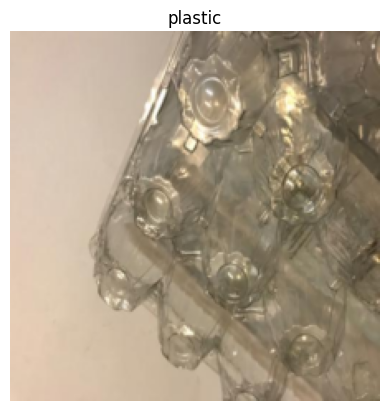

In [10]:
# Plot the Image with matplotlib

plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False);

## 3. Replicating ViT: Overview

* **Inputs** - Images
* **Outputs** - Outside model/layer/block
* **Layers** - Takes an input and manipulates it with a function (equation)
* **Blocks** - A collection of layers
* **Model** - A collection of blocks

#### ViT Architecture

<img src='https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/302ea8d0a64a52f33937084a7c0b9c5249d5f8f2/images/08-vit-paper-figure-1-architecture-overview.png' alt='ViT architecture' width='600px' />

#### ViT Equiations

<img src='https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-four-equations.png' alt='equations' width='600px' />

### 3.1 Equations

**Equiation One:**
```python
# Equation 1
x_input = [class_token, image_patch_1, image_patch_2, ... image_patch_N] + [class_token_pos, image_patch_1_pos, image_patch_2_pos, ... image_patch_N_pos]
```

**Equation 2 & 3:**
```python
# Equation 2
x_output_MSA_block = MSA_layer(LN_layer(x_input)) + x_input

# Equation 3
x_output_MLP_block = MLP_layer(LN_layer(x_output_MSA_block)) + x_output_MSA_block
```

**Equation 4:**
```python
# Equation 4
y = Linear_layer(LN_layer(x_output_MLP_block))
```

### 3.2 Model Variants and Parameters

<img src='https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-table-1.png' alt='table of the different ViT models, same architecture' width='600px' />

ViT-Base, ViT-Large and ViT-Huge are different sizes of the same model architecture.

* **ViT-B/16** = ViT-Base with image patch size 16x16
* **Layers** - the number of transformer encoder layers
* **Hidden size $D$** - the embedding size throughout the architecture
* **MLP size** - the number of hidden units/neurons in the MLP
* **Head** - the number of multi-head self-attention

## 4. Equation One: Split data into patches and create the class, position and patch embedding

Layers = input -> function -> output

* Input shape: $H\times{W}\times{C}$
* Output shape: ${N \times\left(P^{2} \cdot C\right)}$
* H = height
* W = width
* C = color channels
* P = patch size
* N = number of patches = (height * width) / P^2
* D = contant latent vector size = embedding dimension (See on Table 1)

In [11]:
# example values
height = 224
width = 224
color_channels = 3
patch_size = 16

# Calculate the number of patches
number_of_patches = int((height * width) / patch_size ** 2)
number_of_patches

196

In [12]:
# Input shape
embedding_layer_input_shape = (height, width, color_channels)

# Output shape
embedding_layer_output_shape = (number_of_patches, patch_size * patch_size * color_channels)

print(f"Input shape (single 2D image): {embedding_layer_input_shape}")
print(f"Output shape (single 1D sequence of patches): {embedding_layer_output_shape}")


Input shape (single 2D image): (224, 224, 3)
Output shape (single 1D sequence of patches): (196, 768)


### 4.1 Turning a single image into patches

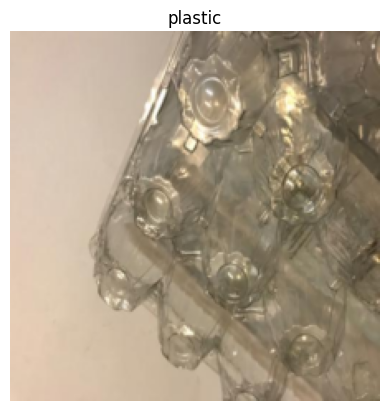

In [13]:
# View a single image
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False);

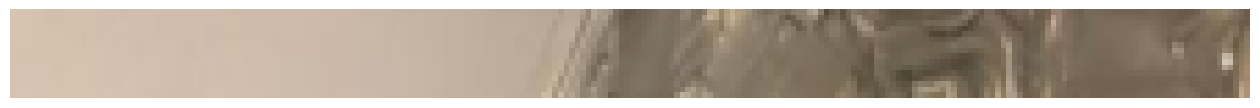

In [14]:
# Get the top row of the image
image_permuted = image.permute(1, 2, 0)

# Index to plot the top row of pixels
patch_size = 16
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size, :, :])
plt.axis(False);

Number of patches per row: 14
Number of patches per column: 14
Total patches: 196
Patch size: 16 pixels x 16 pixels


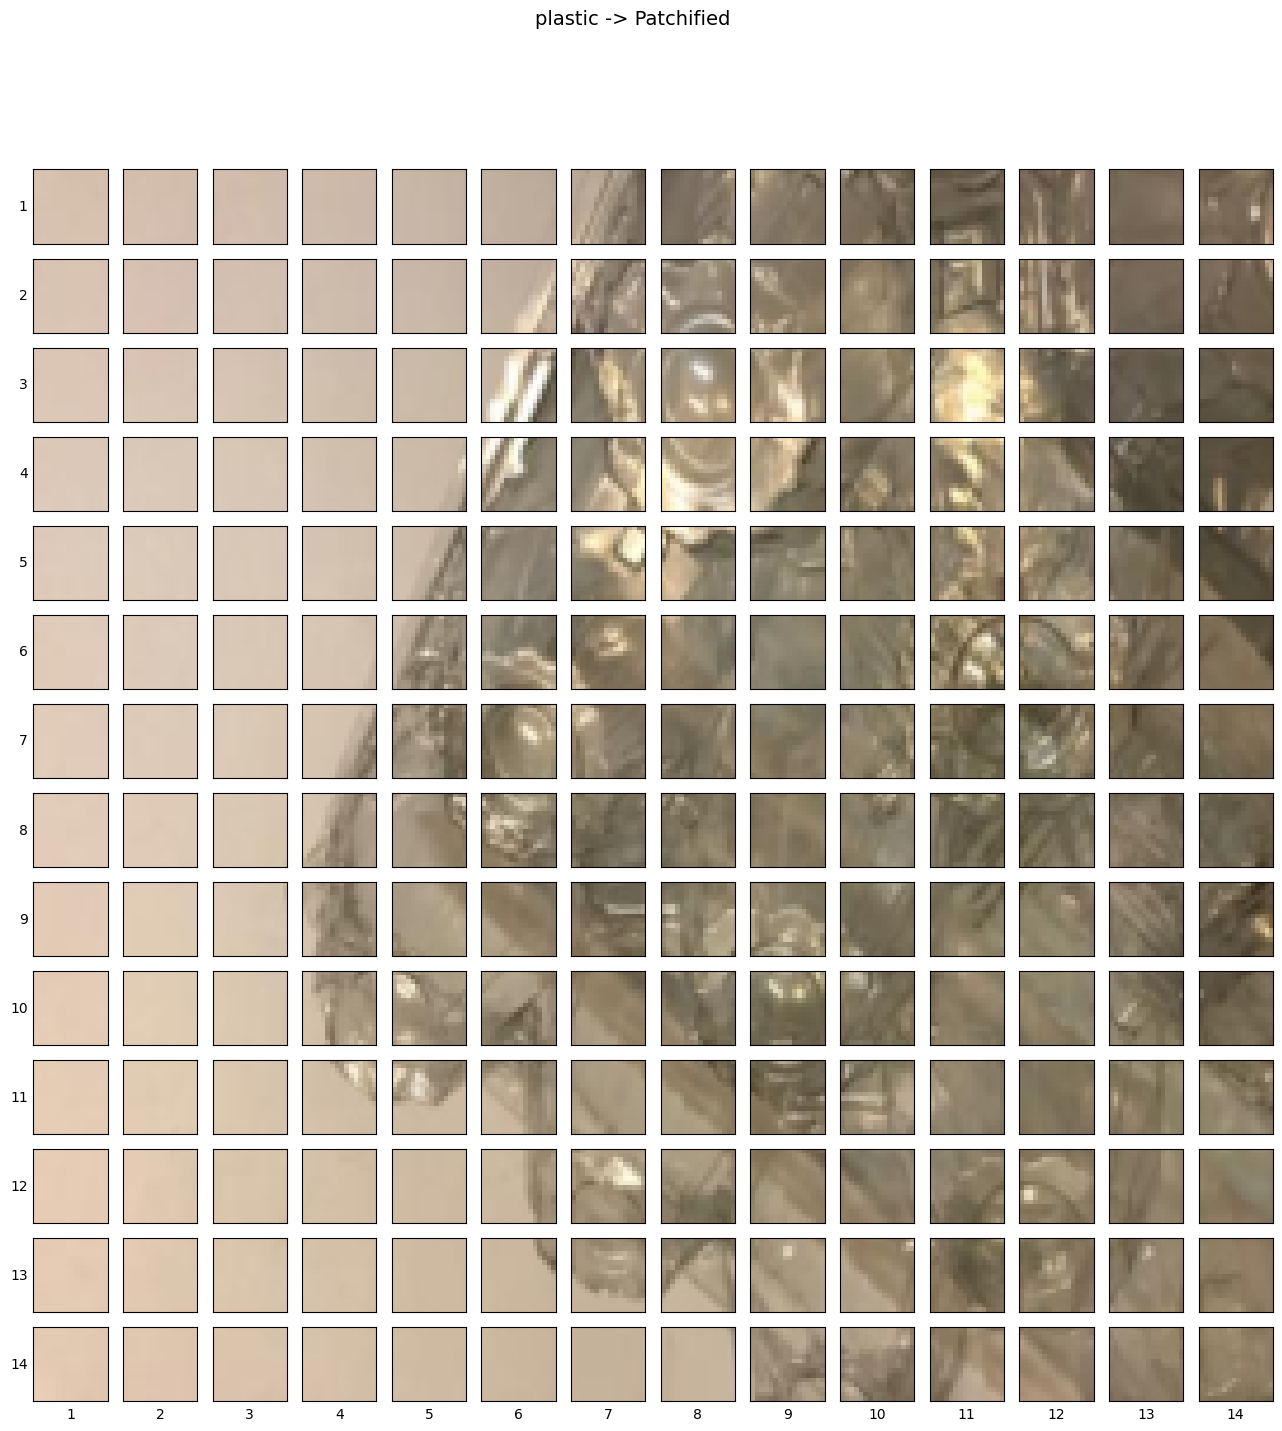

In [15]:
# Setup code to plot top row as patches
img_size = 224
patch_size = 16
num_patches = int(img_size/patch_size)
assert img_size % patch_size == 0, "Image dimensions must be divisible by the patch size"
print(f"Number of patches per row: {num_patches}\nNumber of patches per column: {num_patches}\nTotal patches: {num_patches*num_patches}\nPatch size: {patch_size} pixels x {patch_size} pixels")

# Create a series of subplots
fig, axs = plt.subplots(nrows=num_patches,
                        ncols=num_patches, # One column for each patch
                        sharex=True,
                        sharey=True,
                        figsize=(patch_size, patch_size))

# Iterate through number of patches in the top row
for j, patch_y in enumerate(range(0, img_size, patch_size)):
  for i, patch_x in enumerate(range(0, img_size, patch_size)):
      axs[j][i].imshow(image_permuted[patch_y:patch_y+patch_size, patch_x:patch_x+patch_size, :]);
      axs[j, i].set_ylabel(j+1, rotation="horizontal", horizontalalignment='right', verticalalignment='center')
      axs[j][i].set_xlabel(i+1)
      axs[j][i].set_xticks([])
      axs[j][i].set_yticks([])
      axs[j][i].label_outer()
fig.suptitle(f"{class_names[label]} -> Patchified", fontsize=14)
plt.show()

### 4.3 Creating image patches and turning them into patch embeddings

By using `torch.nn.Conv2d()` and setting the kernel size and stride to `patch_size`.

In [17]:
# Create conv2d layer to turn image into patches of learnable feature maps (embeddings)
from torch import nn

# Set the patch size
patch_size = 16

# Create a conv2d layer with hyperparameters from the ViT paper
conv2d = nn.Conv2d(in_channels=3, #for color images
                   out_channels=768, # D size from table 1,
                   kernel_size=patch_size,
                   stride=patch_size,
                   padding=0)
conv2d

Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))

In [19]:
# Pass the image thrpught the convolutional layer
image_out_of_conv = conv2d(image.unsqueeze(0)) # add batch dimension -> (batch_size, color_channels, height, width)
print(f"{image_out_of_conv.shape} [batch_size, embedding_dim, feature_map_height, feature_map_width]")

torch.Size([1, 768, 14, 14]) [batch_size, embedding_dim, feature_map_height, feature_map_width]


In [ ]:
# plot ramdon convolutional feature maps (embeddings)
import random
random_indexes = random.sample(range(0, 758), k=5)
print(f"Showing random convolution feature maps from indexes: {random_indexes}")

# Create plot
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12,12))

# Plot random image feature maps
for i, idx in enumarate(random_indexes):
